<a href="https://colab.research.google.com/github/idrisinanoglu/DSA210-Project/blob/main/DSA_210.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install meteostat pytrends

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from meteostat import Point, Daily
from pytrends.request import TrendReq

plt.style.use("default")
sns.set()

# Istanbul coordinates
istanbul = Point(41.0082, 28.9784)

start = datetime(2022, 1, 1)
end = datetime(2024, 12, 31)

# Download daily weather data
weather_daily = Daily(istanbul, start, end).fetch()

weather_daily.head()

weather_daily.to_csv("weather_istanbul_2022_2024.csv")
print("Istanbul weather CSV file saved!")


Istanbul weather CSV file saved!


In [ ]:
from pytrends.request import TrendReq
import pandas as pd

# Initialize Pytrends connection
pytrends = TrendReq(hl='tr-TR', tz=180)

# keywords by category

# 1) NEGATIVE MOOD
negative_mood = [
    "depresyon",
    "kaygı",
    "anksiyete",
    "stres",
    "bunalım"
]

# 2) POSITIVE MOOD
positive_mood = [
    "mutlu",
    "mutluluk",
    "huzurlu",
    "iyi hissetmek"
]

# 3) NEGATIVE BEHAVIORAL
negative_behavior = [
    "yalnızlık",
    "uykusuzluk",
    "yorgunluk"
]

# 4) POSITIVE BEHAVIORAL
positive_behavior = [
    "spor salonu",
    "yürüyüş"
]


all_keywords = negative_mood + positive_mood + negative_behavior + positive_behavior
len(all_keywords), all_keywords


# Google Trends request groups since i cant search for more than 5 at the same time
group1 = [
    "depresyon",
    "kaygı",
    "anksiyete",
    "stres",
    "bunalım"
]

group2 = [
    "mutlu",
    "mutluluk",
    "huzurlu",
    "iyi hissetmek"
]

group3 = [
    "yalnızlık",
    "uykusuzluk",
    "yorgunluk"
]

group4 = [
    "spor salonu",
    "yürüyüş"
]

def get_trends_for_group(kw_list):
    pytrends.build_payload(
        kw_list=kw_list,
        geo='TR',
        timeframe='2022-01-01 2024-12-31'
    )
    df = pytrends.interest_over_time()
    if "isPartial" in df.columns:
        df = df.drop(columns=["isPartial"])
    return df


trends1 = get_trends_for_group(group1)
trends2 = get_trends_for_group(group2)
trends3 = get_trends_for_group(group3)
trends4 = get_trends_for_group(group4)


trends = pd.concat(
    [
        trends1,
        trends2[group2],
        trends3[group3],
        trends4[group4]
    ],
    axis=1
)

trends.head(), trends.columns




(            depresyon  kaygı  anksiyete  stres  bunalım  mutlu  mutluluk  \
 date                                                                       
 2021-12-26         30     15         53     44        3    100        13   
 2022-01-02         42     17         66     52        2     67        12   
 2022-01-09         38     16         61     50        2     56        12   
 2022-01-16         33     14         53     41        2     48        11   
 2022-01-23         35     15         61     45        2     55        12   
 
             huzurlu  iyi hissetmek  yalnızlık  uykusuzluk  yorgunluk  \
 date                                                                   
 2021-12-26        2              1         26          13         18   
 2022-01-02        2              2         26          14         19   
 2022-01-09        2              1         26          16         18   
 2022-01-16        2              1         24          13         13   
 2022-01-23        2 

In [ ]:

negative_mood = ["depresyon", "kaygı", "anksiyete", "stres", "bunalım"]
positive_mood = ["mutlu", "mutluluk", "huzurlu", "iyi hissetmek"]

negative_behavior = ["yalnızlık", "uykusuzluk", "yorgunluk"]
positive_behavior = ["spor salonu", "yürüyüş"]


trends["NegativeMoodIndex"] = trends[negative_mood].mean(axis=1)
trends["PositiveMoodIndex"] = trends[positive_mood].mean(axis=1)
trends["NegativeBehaviorIndex"] = trends[negative_behavior].mean(axis=1)
trends["PositiveBehaviorIndex"] = trends[positive_behavior].mean(axis=1)

trends[[
    "NegativeMoodIndex",
    "PositiveMoodIndex",
    "NegativeBehaviorIndex",
    "PositiveBehaviorIndex"
]].head()


,NegativeMoodIndex,PositiveMoodIndex,NegativeBehaviorIndex,PositiveBehaviorIndex
date,,,,
2021-12-26,29.0,29.00,19.000000,33.0
2022-01-02,35.8,20.75,19.666667,39.0
2022-01-09,33.4,17.75,20.000000,40.5
2022-01-16,28.6,15.50,16.666667,36.5
2022-01-23,31.6,17.50,17.333333,37.0


In [ ]:
import pandas as pd

# load daily weatherCSV
weather_daily = pd.read_csv("weather_istanbul_2022_2024.csv", index_col=0)

# convert index to datetime
weather_daily.index = pd.to_datetime(weather_daily.index)

weather_daily.head()

# Convert to weekly averages because google trends gives data weekly
weather_weekly = weather_daily.resample("W").mean()

weather_weekly.head()

trends.index = pd.to_datetime(trends.index)

# combine weekly weather + Google Trends + indices
combined = weather_weekly.join(trends, how="inner")

combined.head(), combined.columns

combined.to_csv("combined_weather_trends_istanbul_TR_2022_2024.csv")
print("Saved: combined_weather_trends_istanbul_TR_2022_2024.csv")


Saved: combined_weather_trends_istanbul_TR_2022_2024.csv


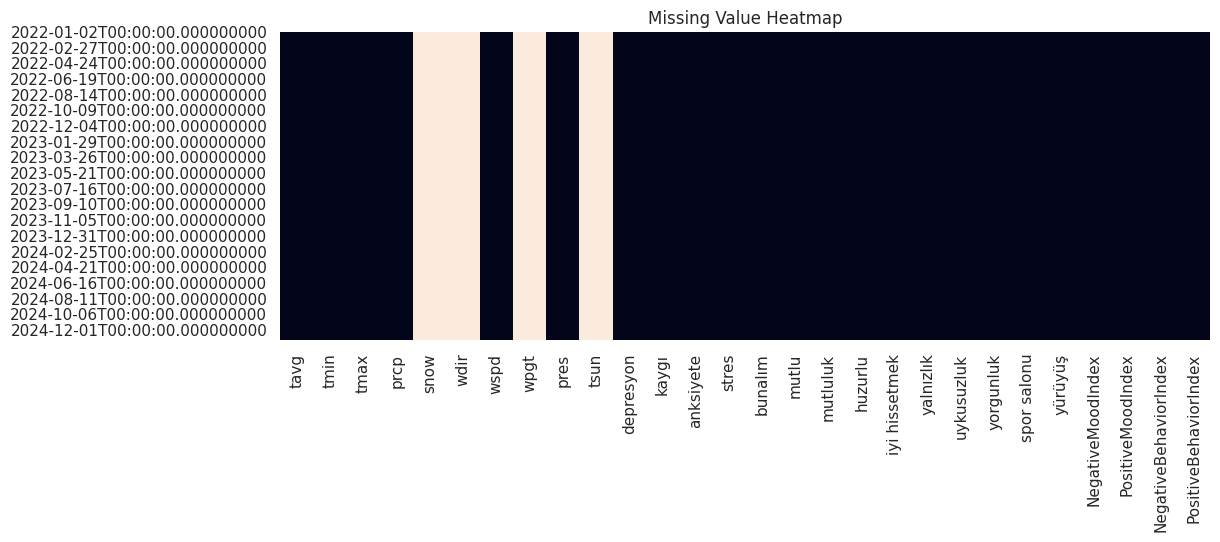

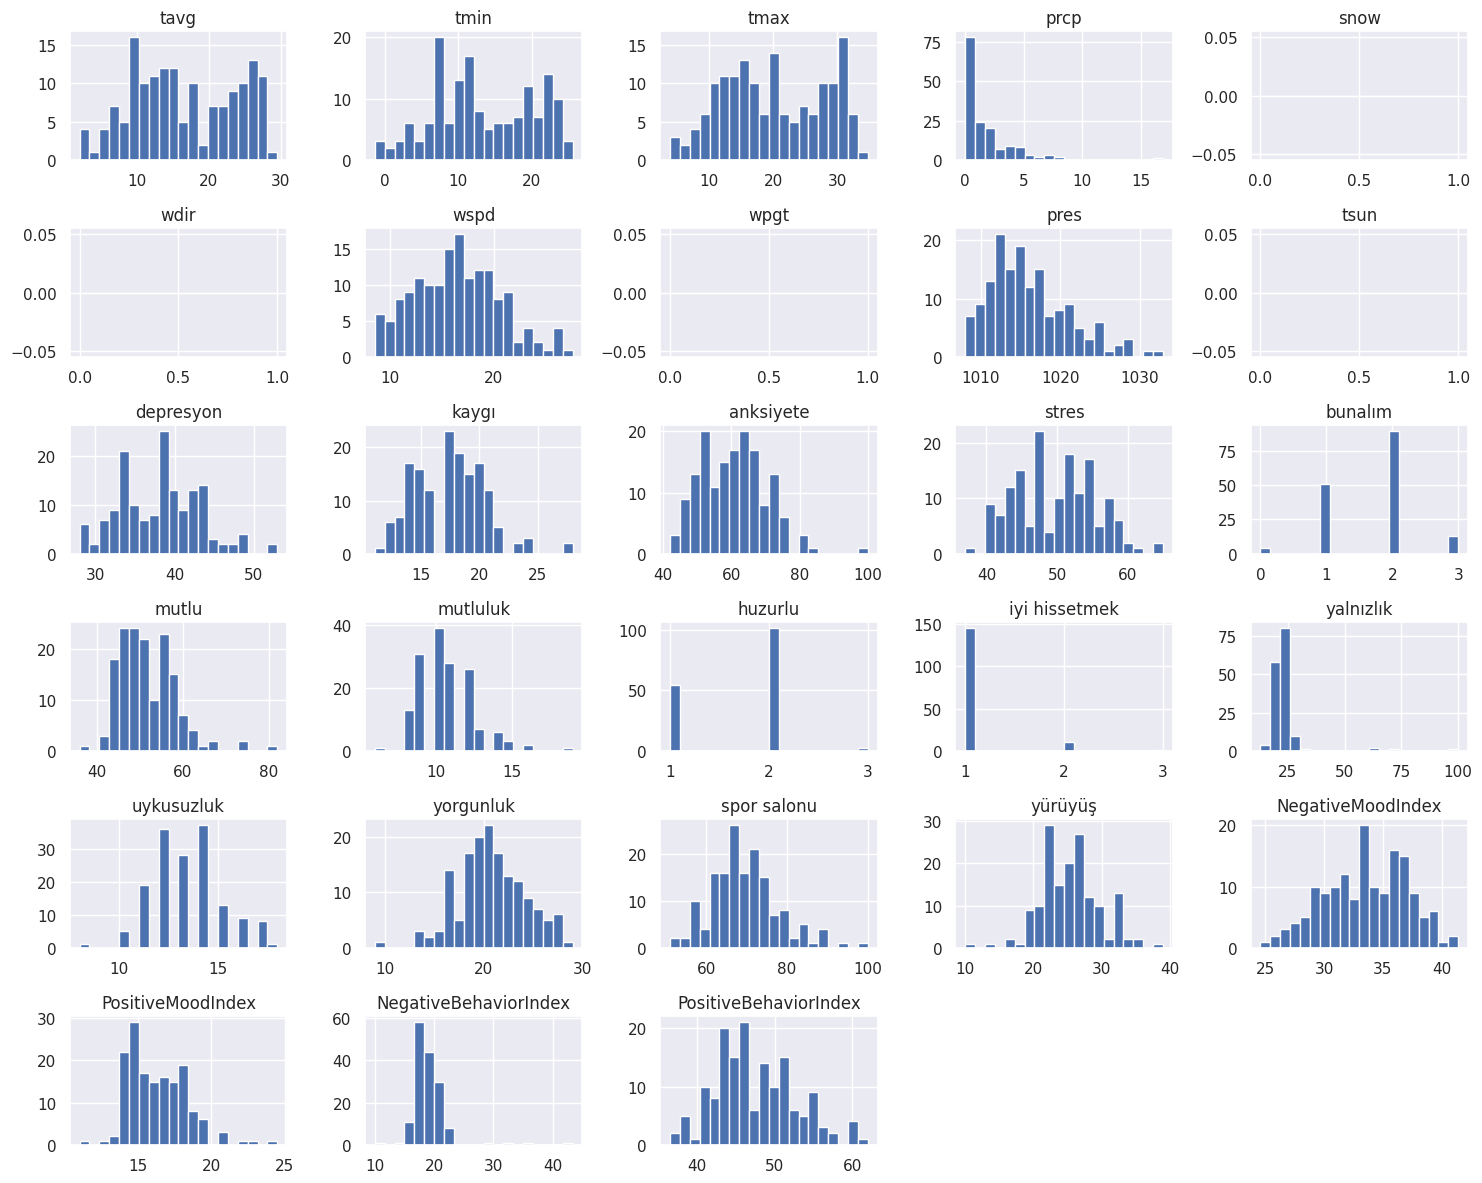

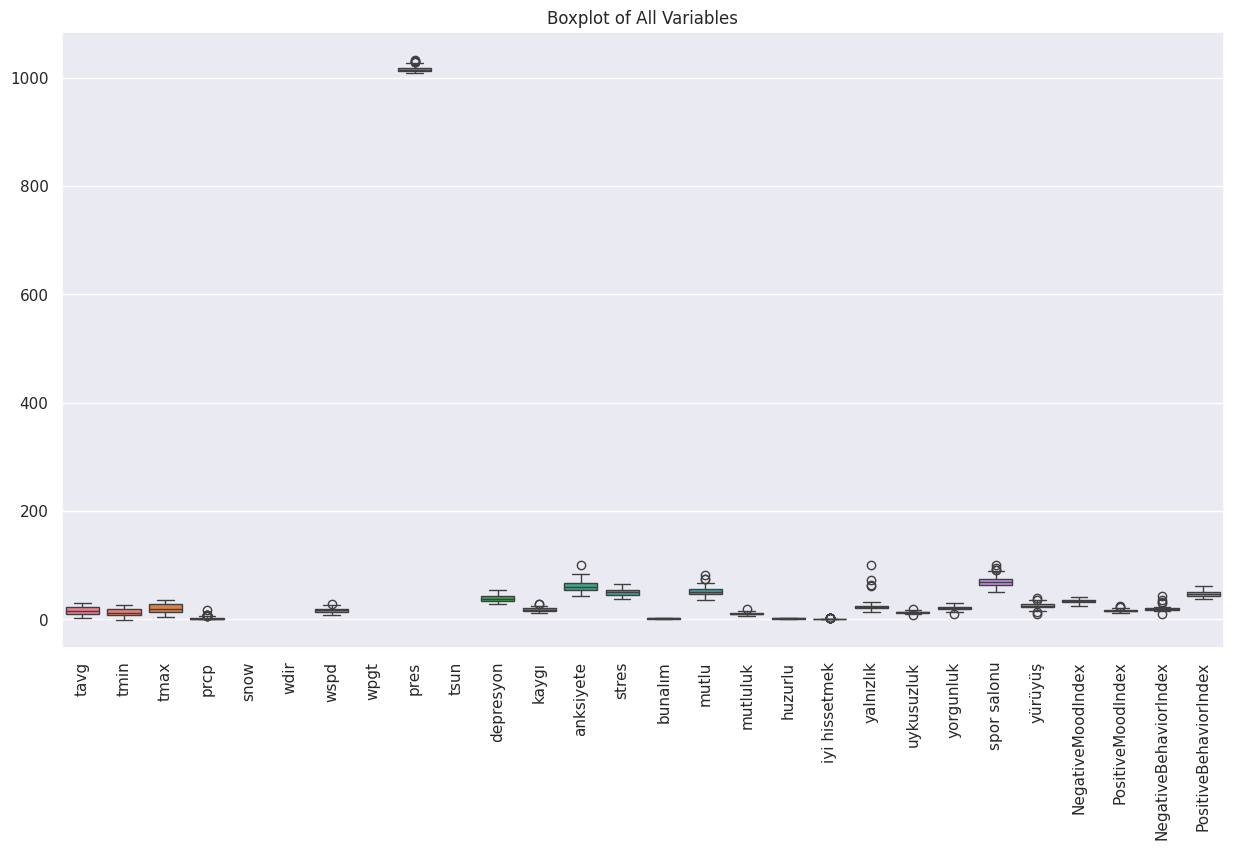

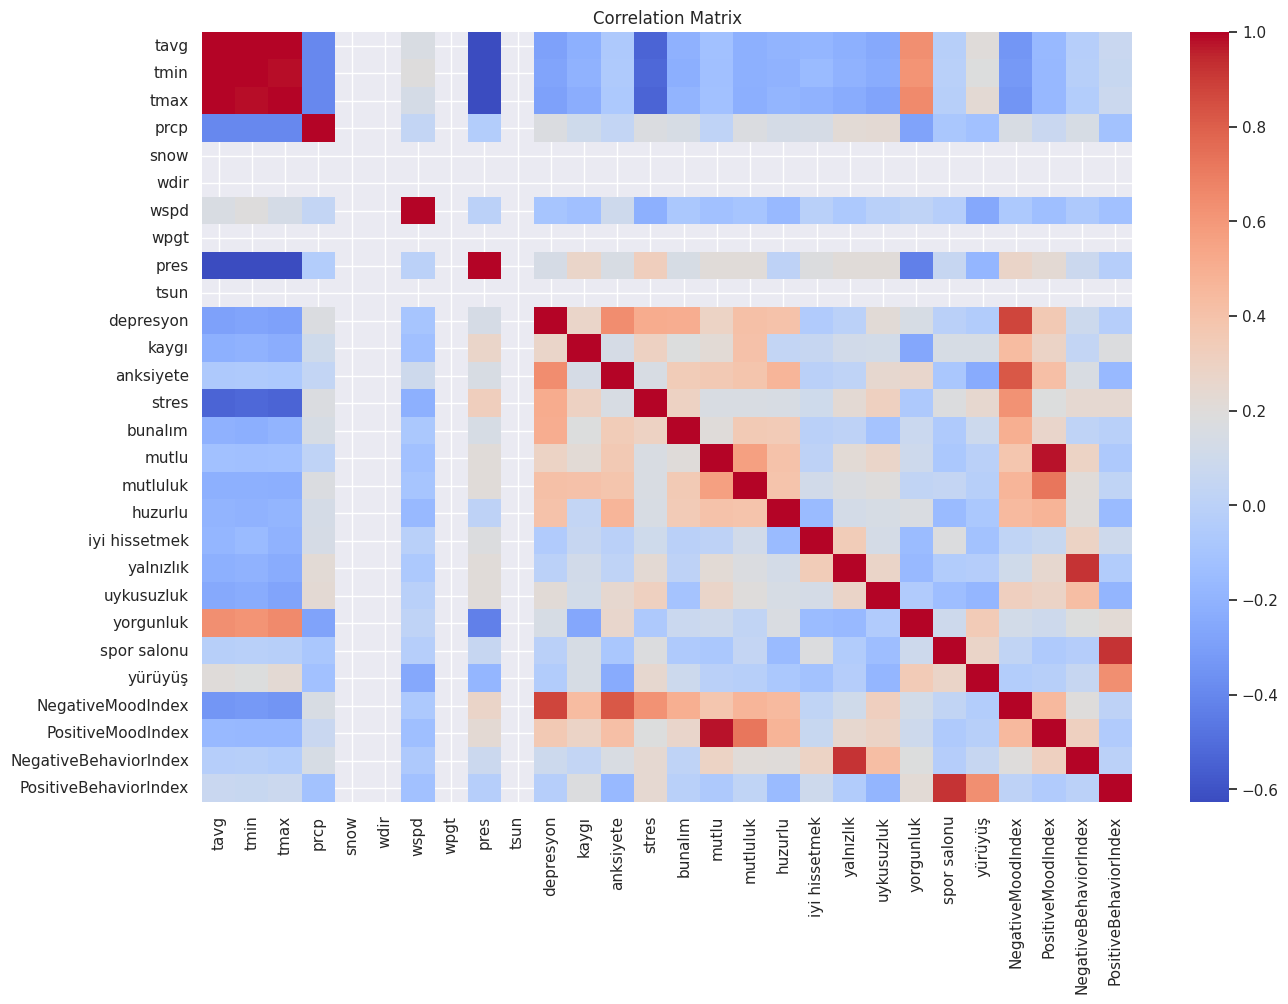

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load dataset
df = pd.read_csv("combined_weather_trends_istanbul_TR_2022_2024.csv", index_col=0)
df.index = pd.to_datetime(df.index)

df.head()

df.describe().T
df.isna().sum()

plt.figure(figsize=(12,4))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()

df.hist(figsize=(15,12), bins=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,8))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Boxplot of All Variables")
plt.show()

plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


T-test: NegativeMoodIndex (Rainy vs Dry)
t-statistic: 1.5709192368793077
p-value    : 0.12926489000273828
ANOVA: PositiveBehaviorIndex ~ Temperature Group
F-statistic: 0.7096396233619917
p-value    : 0.49342247609803513
Chi-square test: HighNegativeMood vs Rain
Chi2 statistic: 1.091871751137101
p-value       : 0.2960568611714851
Degrees of freedom: 1
Contingency table:
 is_rainy           0   1
HighNegativeMood        
0                 13  68
1                  7  69


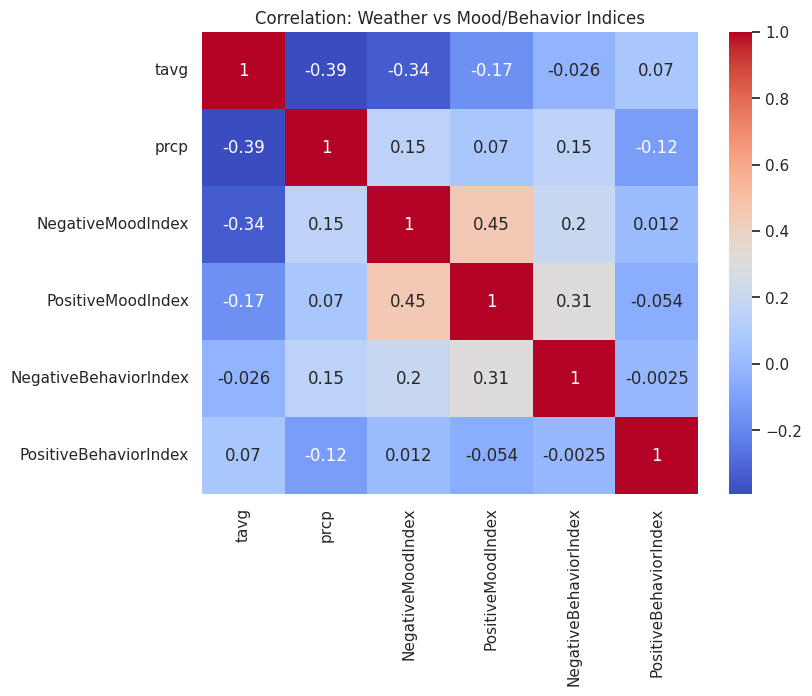

In [ ]:
from scipy import stats
from scipy.stats import f_oneway, chi2_contingency

df = pd.read_csv("combined_weather_trends_istanbul_TR_2022_2024.csv", index_col=0)
df.index = pd.to_datetime(df.index)

df.head()

# rainy vs. dry weeks
df["is_rainy"] = (df["prcp"] > 0).astype(int)

# cold / mild / warm
df["temp_group"] = pd.cut(
    df["tavg"],
    bins=[-50, 10, 20, 50],          # <10, 10-20, >20 degrees
    labels=["cold", "mild", "warm"]
)

# high vs low negative mood relative to median
median_neg_mood = df["NegativeMoodIndex"].median()
df["HighNegativeMood"] = (df["NegativeMoodIndex"] > median_neg_mood).astype(int)

rainy = df[df["is_rainy"] == 1]["NegativeMoodIndex"].dropna()
dry   = df[df["is_rainy"] == 0]["NegativeMoodIndex"].dropna()

t_stat, p_val = stats.ttest_ind(rainy, dry, equal_var=False)

print("T-test: NegativeMoodIndex (Rainy vs Dry)")
print("t-statistic:", t_stat)
print("p-value    :", p_val)

cold = df[df["temp_group"] == "cold"]["PositiveBehaviorIndex"].dropna()
mild = df[df["temp_group"] == "mild"]["PositiveBehaviorIndex"].dropna()
warm = df[df["temp_group"] == "warm"]["PositiveBehaviorIndex"].dropna()

f_stat, p_val = f_oneway(cold, mild, warm)

print("ANOVA: PositiveBehaviorIndex ~ Temperature Group")
print("F-statistic:", f_stat)
print("p-value    :", p_val)

ct = pd.crosstab(df["HighNegativeMood"], df["is_rainy"])

chi2, p_val, dof, expected = chi2_contingency(ct)

print("Chi-square test: HighNegativeMood vs Rain")
print("Chi2 statistic:", chi2)
print("p-value       :", p_val)
print("Degrees of freedom:", dof)
print("Contingency table:\n", ct)

cols_of_interest = [
    "tavg", "prcp",
    "NegativeMoodIndex", "PositiveMoodIndex",
    "NegativeBehaviorIndex", "PositiveBehaviorIndex"
]

corr_subset = df[cols_of_interest].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_subset, annot=True, cmap="coolwarm")
plt.title("Correlation: Weather vs Mood/Behavior Indices")
plt.show()
